# c) Region Segmentation Using Traditional Techniques

In [11]:
import cv2
import numpy as np
import os
from glob import glob

# Function to compute IoU
def calculate_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    return intersection / union if union != 0 else 0

# Function to compute Dice Score
def calculate_dice(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    return (2.0 * intersection) / (pred_mask.sum() + gt_mask.sum()) if (pred_mask.sum() + gt_mask.sum()) != 0 else 0

# Function to resize masks to match ground truth shape
def resize_mask(mask, target_shape):
    return cv2.resize(mask, (target_shape[1], target_shape[0]), interpolation=cv2.INTER_NEAREST)

# Simple Binary Thresholding
def thresholding(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    return binary

# Otsu’s Thresholding
def otsu_thresholding(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary

# Edge Detection
def edge_detection(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    return edges

# Watershed Segmentation
def watershed_segmentation(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Noise removal
    kernel = np.ones((3,3), np.uint8)
    sure_bg = cv2.dilate(binary, kernel, iterations=3)
    
    # Distance transform and thresholding
    dist_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labelling
    markers = cv2.connectedComponents(sure_fg)[1] + 1
    markers[unknown == 255] = 0

    # Apply watershed
    img_bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)  # Convert to 3-channel BGR
    markers = cv2.watershed(img_bgr, markers)
    
    return (markers > 1).astype(np.uint8) * 255  # Return binary mask

# Paths to dataset
face_crop_folder = r"segmentation_dataset/1/face_crop"
face_crop_segmentation_folder = r"segmentation_dataset/1/face_crop_segmentation"

# Get all image paths
face_crop_images = sorted(glob(os.path.join(face_crop_folder, "*.jpg")))
gt_masks = sorted(glob(os.path.join(face_crop_segmentation_folder, "*.jpg")))

# Store IoU and Dice scores
iou_scores = {"Thresholding": [], "Otsu": [], "Edge Detection": [], "Watershed": []}
dice_scores = {"Thresholding": [], "Otsu": [], "Edge Detection": [], "Watershed": []}

# Process each image
for img_path, gt_path in zip(face_crop_images, gt_masks):
    img = cv2.imread(img_path)
    gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

    gt_mask = (gt_mask > 0).astype(np.uint8)  # Convert GT to binary

    # Apply methods
    methods = {
        "Thresholding": thresholding(img),
        "Otsu": otsu_thresholding(img),
        "Edge Detection": edge_detection(img),
        "Watershed": watershed_segmentation(img)
    }

    for method, pred_mask in methods.items():
        pred_mask = (pred_mask > 0).astype(np.uint8)  # Convert to binary

        # Resize pred_mask to match gt_mask shape
        pred_mask = resize_mask(pred_mask, gt_mask.shape)

        # Compute IoU and Dice
        iou_scores[method].append(calculate_iou(pred_mask, gt_mask))
        dice_scores[method].append(calculate_dice(pred_mask, gt_mask))

# Compute and print average scores
for method in iou_scores.keys():
    avg_iou = np.mean(iou_scores[method])
    avg_dice = np.mean(dice_scores[method])
    print(f"{method} - Avg IoU: {avg_iou:.4f}, Avg Dice: {avg_dice:.4f}")


Thresholding - Avg IoU: 0.2749, Avg Dice: 0.4030
Otsu - Avg IoU: 0.2899, Avg Dice: 0.4233
Edge Detection - Avg IoU: 0.0822, Avg Dice: 0.1461
Watershed - Avg IoU: 0.2140, Avg Dice: 0.2956


* Applied 4 different traditional methods for region segmentation and Otsu Threshold method had the highest average IoU and Dice scores.

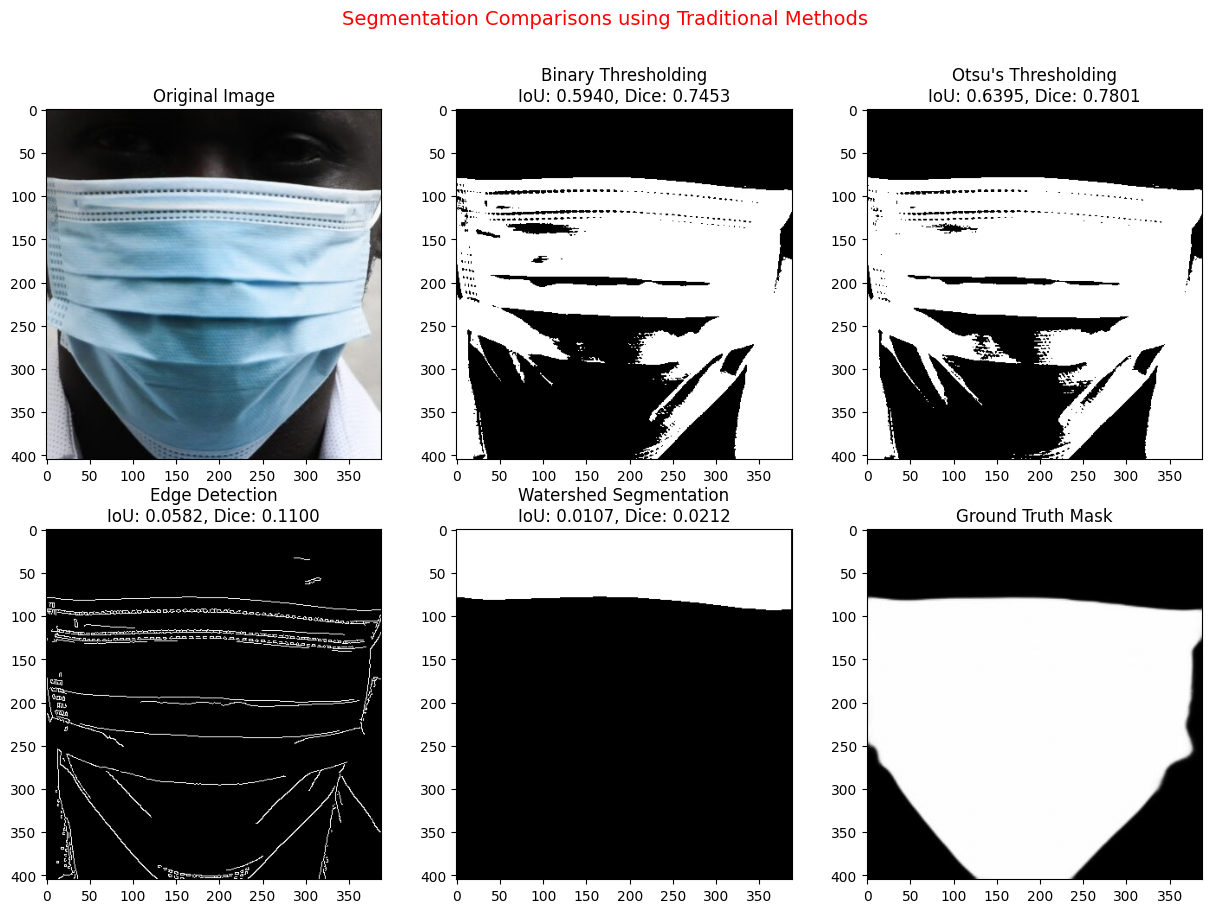

Binary Thresholding: IoU = 0.5940, Dice Score = 0.7453
Otsu's Thresholding: IoU = 0.6395, Dice Score = 0.7801
Edge Detection: IoU = 0.0582, Dice Score = 0.1100
Watershed Segmentation: IoU = 0.0107, Dice Score = 0.0212


In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image and ground truth mask
image_path = r"segmentation_dataset/1/face_crop/000000_1.jpg"
mask_path = r"segmentation_dataset/1/face_crop_segmentation/000000_1.jpg"

image = cv2.imread(image_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Ground truth mask

# Ensure the ground truth mask is binary
mask2 = (mask > 0).astype(np.float32)

# ---------------------- 1. Simple Binary Thresholding ----------------------
def thresholding(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    return binary

# ---------------------- 2. Otsu’s Thresholding ----------------------
def otsu_thresholding(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary

# ---------------------- 3. Edge Detection ----------------------
def edge_detection(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    return edges

# ---------------------- 4. Watershed Segmentation ----------------------
def watershed_segmentation(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Noise removal
    kernel = np.ones((3,3), np.uint8)
    sure_bg = cv2.dilate(binary, kernel, iterations=3)
    
    # Distance transform and thresholding
    dist_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labelling
    markers = cv2.connectedComponents(sure_fg)[1] + 1
    markers[unknown == 255] = 0

    # Apply watershed
    img_bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)  # Convert to 3-channel BGR
    markers = cv2.watershed(img_bgr, markers)
    
    return (markers > 1).astype(np.uint8) * 255  # Return binary mask

# ---------------------- Compute IoU and Dice Score ----------------------
def compute_metrics(binary_mask, mask2):
    """Compute IoU and Dice Score."""
    binary_mask = (binary_mask > 0).astype(np.float32)  # Ensure binary
    intersection = np.logical_and(mask2, binary_mask).sum()
    union = np.logical_or(mask2, binary_mask).sum()
    iou = intersection / union if union != 0 else 0  # Avoid division by zero
    dice = (2 * intersection) / (mask2.sum() + binary_mask.sum()) if (mask2.sum() + binary_mask.sum()) != 0 else 0
    return iou, dice

# Apply the segmentation techniques
binary_mask = thresholding(image)
otsu_mask = otsu_thresholding(image)
edge_mask = edge_detection(image)
watershed_mask = watershed_segmentation(image)

# Calculate IoU and Dice Scores
metrics = {
    "Binary Thresholding": compute_metrics(binary_mask, mask2),
    "Otsu's Thresholding": compute_metrics(otsu_mask, mask2),
    "Edge Detection": compute_metrics(edge_mask, mask2),
    "Watershed Segmentation": compute_metrics(watershed_mask, mask2)
}

# ---------------------- Display Results ----------------------
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(2, 3, 2)
plt.title(f"Binary Thresholding\nIoU: {metrics['Binary Thresholding'][0]:.4f}, Dice: {metrics['Binary Thresholding'][1]:.4f}")
plt.imshow(binary_mask, cmap='gray')

plt.subplot(2, 3, 3)
plt.title(f"Otsu's Thresholding\nIoU: {metrics['Otsu\'s Thresholding'][0]:.4f}, Dice: {metrics['Otsu\'s Thresholding'][1]:.4f}")
plt.imshow(otsu_mask, cmap='gray')

plt.subplot(2, 3, 4)
plt.title(f"Edge Detection\nIoU: {metrics['Edge Detection'][0]:.4f}, Dice: {metrics['Edge Detection'][1]:.4f}")
plt.imshow(edge_mask, cmap='gray')

plt.subplot(2, 3, 5)
plt.title(f"Watershed Segmentation\nIoU: {metrics['Watershed Segmentation'][0]:.4f}, Dice: {metrics['Watershed Segmentation'][1]:.4f}")
plt.imshow(watershed_mask, cmap='gray')

plt.subplot(2, 3, 6)
plt.title("Ground Truth Mask")
plt.imshow(mask, cmap='gray')

plt.suptitle("Segmentation Comparisons using Traditional Methods", fontsize=14, color='red')
plt.show()

# Print IoU and Dice Scores
for method, (iou, dice) in metrics.items():
    print(f"{method}: IoU = {iou:.4f}, Dice Score = {dice:.4f}")


* Visualised the 4 segmentation techniques for a sample image. Here also we can see that out of these 4 Otsu's thresholding is performing the best.

# d) Mask Segmentation Using U-Net

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.optimizers import Adam


2025-03-24 20:35:59.276832: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 20:35:59.688672: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742828759.844913    3067 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742828759.883469    3067 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-24 20:36:00.367527: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
import tensorflow as tf
import numpy as np
import os
import glob

# Set image size and batch size
IMG_SIZE = 256
BATCH_SIZE = 8

# Paths to dataset folders
IMAGE_DIR = "segmentation_dataset/1/face_crop"
MASK_DIR = "segmentation_dataset/1/face_crop_segmentation"

# Get sorted lists of image and mask files
image_files = sorted(glob.glob(os.path.join(IMAGE_DIR, "*.jpg")))
mask_files = sorted(glob.glob(os.path.join(MASK_DIR, "*.jpg")))

# Train-test split
train_imgs, test_imgs, train_masks, test_masks = train_test_split(image_files, mask_files, test_size=0.2, random_state=21)

# Function to load and preprocess image-mask pairs
def parse_image(img_path, mask_path):
    # Read and decode images
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0

    # Read and decode masks
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)  # Ensure single channel for mask
    mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = tf.cast(mask > 127, tf.float32)

    return img, mask

# Create dataset
def create_dataset(imgs, masks):
    ds = tf.data.Dataset.from_tensor_slices((imgs, masks))
    ds = ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset = create_dataset(train_imgs, train_masks)
test_dataset = create_dataset(test_imgs, test_masks)

# Print dataset shapes to verify
for img, mask in train_dataset.take(1):
    print(f"Image shape: {img.shape}, Mask shape: {mask.shape}")


Image shape: (8, 256, 256, 3), Mask shape: (8, 256, 256, 1)


2025-03-24 20:36:10.157748: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

def dice_metric(y_true, y_pred):
    y_true = K.cast(y_true, dtype="float32")  # Convert to float32
    intersection = K.sum(y_true * y_pred)
    denominator = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + K.epsilon()) / (denominator + K.epsilon())


def iou_metric(y_true, y_pred):
    y_true = K.cast(y_true, dtype="float32")  # Ensure same type
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + K.epsilon()) / (union + K.epsilon())

def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder (Downsampling)
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    c1 = layers.BatchNormalization()(c1)  # Added BatchNorm
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
    c1 = layers.Dropout(0.1)(c1)  # Added Dropout
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
    c2 = layers.Dropout(0.1)(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c3)
    c3 = layers.Dropout(0.2)(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(c4)
    c4 = layers.Dropout(0.3)(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation="relu", padding="same")(p4)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Conv2D(1024, (3, 3), activation="relu", padding="same")(c5)
    c5 = layers.Dropout(0.3)(c5)

    # Decoder (Upsampling + Skip Connections)
    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.Conv2D(512, (2, 2), activation="relu", padding="same")(u6)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(u6)
    c6 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(c6)

    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.Conv2D(256, (2, 2), activation="relu", padding="same")(u7)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(u7)
    c7 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c7)

    u8 = layers.UpSampling2D((2, 2))(c7)
    u8 = layers.Conv2D(128, (2, 2), activation="relu", padding="same")(u8)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(u8)
    c8 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c8)

    u9 = layers.UpSampling2D((2, 2))(c8)
    u9 = layers.Conv2D(64, (2, 2), activation="relu", padding="same")(u9)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(u9)
    c9 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c9)

    # Final Segmentation Output
    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(c9)

    # Build Model
    model = models.Model(inputs, outputs)

    # Compile with Adam, IoU, and Dice Metric
    model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=[iou_metric, dice_metric])

    return model

# Initialize and compile the model
model = unet_model()
model.summary()  # Print model summary


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ dropout_1[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ dropout_2[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[

 Total params: 31,039,681 (118.41 MB)

 Trainable params: 31,035,713 (118.39 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [5]:
# Train U-Net Model
history = model.fit(train_dataset, epochs=10)


Epoch 1/10


I0000 00:00:1742828783.244254    3230 service.cc:148] XLA service 0x7b892c0319c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742828783.244429    3230 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-03-24 20:36:23.381357: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742828783.986374    3230 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-24 20:36:26.358520: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.58GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-24 20:36:27.329345: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_b

939/939 ━━━━━━━━━━━━━━━━━━━━ 321s 306ms/step - dice_metric: 0.6507 - iou_metric: 0.4899 - loss: 0.3600
Epoch 2/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 275s 293ms/step - dice_metric: 0.7298 - iou_metric: 0.5753 - loss: 0.2840
Epoch 3/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 275s 293ms/step - dice_metric: 0.7347 - iou_metric: 0.5815 - loss: 0.2784
Epoch 4/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 275s 293ms/step - dice_metric: 0.7374 - iou_metric: 0.5847 - loss: 0.2757
Epoch 5/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 275s 293ms/step - dice_metric: 0.7393 - iou_metric: 0.5871 - loss: 0.2736
Epoch 6/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 275s 293ms/step - dice_metric: 0.7418 - iou_metric: 0.5903 - loss: 0.2709
Epoch 7/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 275s 293ms/step - dice_metric: 0.7444 - iou_metric: 0.5935 - loss: 0.2684
Epoch 8/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 275s 293ms/step - dice_metric: 0.7473 - iou_metric: 0.5973 - loss: 0.2652
Epoch 9/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 275s 293ms/step - dice_metric: 0.7510 - iou_metric: 0.6020 

In [8]:
print("\nTesting Metrics:")
val_metrics = model.evaluate(test_dataset)
print(f"IoU Score: {val_metrics[1]:.4f}")
print(f"Dice Score:  {val_metrics[2]:.4f}")


Testing Metrics:
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - dice_metric: 0.7212 - iou_metric: 0.5647 - loss: 0.2908
IoU Score: 0.5655
Dice Score:  0.7219


In [12]:
for method in iou_scores.keys():
    avg_iou = np.mean(iou_scores[method])
    avg_dice = np.mean(dice_scores[method])
    print(f"{method} - Avg IoU: {avg_iou:.4f}, Avg Dice: {avg_dice:.4f}")
print(f"U-Net - Avg IoU: {val_metrics[1]:.4f}, Avg Dice: {val_metrics[2]:.4f}")

Thresholding - Avg IoU: 0.2749, Avg Dice: 0.4030
Otsu - Avg IoU: 0.2899, Avg Dice: 0.4233
Edge Detection - Avg IoU: 0.0822, Avg Dice: 0.1461
Watershed - Avg IoU: 0.2140, Avg Dice: 0.2956
U-Net - Avg IoU: 0.5655, Avg Dice: 0.7219


* Here we can see that U-Net performs the best. It is ahead of other methods by a very large margin.
* Also the traditional method used, require parameter tuning for each individual image to get good score but it is not scalable for large dataset like ours, thus U-Net outperforms the traditional methods.